In [1]:
import numpy as np
import porespy as ps
import matplotlib.pyplot as plt
import scipy.io as sio
import skimage as ski
import tqdm
import os
import seaborn as sns
import pandas as pd
from pathlib import Path
import pickle as pkl
import plotly.express as px
import plotly.graph_objects as go

from decimal import Decimal
cwd = Path().resolve()

In [4]:
# Define overall variables used to analyze the data
resolution = 16.81E-6 # adding resolution in meters
lowFlowVelCutoff = 7.16 * 10 ** float(-6) #0.000207 # 5.13 * 10 ** float(-5) # 0.5 * 10 ** float(-5)
poreDiamThresh = 20
poreVolumeThresh = 100000
simPressure = 0.00005 # This is currently hardcoded!!
imageSize = 512

filePath = cwd / 'subBeadPackPy512_justSpheres.npy'
primaryImage = np.load(filePath)

filePath = cwd / 'finalSimFile3D512.npy'
secondaryImage = np.load(filePath)
primaryImage[primaryImage == 255] = 1

primaryImage = np.transpose(primaryImage)
secondaryImage = np.transpose(secondaryImage)

filePath = cwd / 'primarySnowOut.npy'
primarySnow = np.load(filePath)
filePath = cwd / 'primaryPoreInfo.p'
#primaryInfo = np.load(filePath,allow_pickle=True)
poreInfoPrimary = pkl.load(open(filePath,'rb'))

filePath = cwd / 'secondarySnowOut.npy'
secondarySnow = np.load(filePath)
filePath = cwd / 'secondaryPoreInfo.p'
#secondaryInfo = np.load(filePath,allow_pickle=True)
poreInfoSecondary = pkl.load(open(filePath,"rb"))

In [5]:
filePath = cwd / 'velocityFiles' / 'velocityNormCodeSecondary_0.00005.mat'
velSecondaryMat = sio.loadmat(filePath)
velDataNormSecondary = velSecondaryMat['velNorm']

filePath = cwd / 'velocityFiles' / 'velocityNormCodePrimary_0.00005.mat'
velPrimaryMat = sio.loadmat(filePath)
velDataNormPrimary = velPrimaryMat['velNorm']


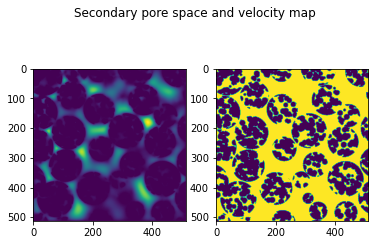

In [6]:
slice = 35

fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Secondary pore space and velocity map')
p1.imshow(velDataNormSecondary[:,:,slice])
p2.imshow(secondaryImage[:,:,slice])

fig.savefig('secondaryPoreImage.png', dpi=300, facecolor='w', edgecolor='w')

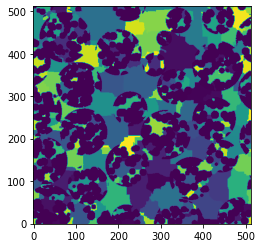

In [7]:
plt.imshow(ps.tools.randomize_colors(secondarySnow[:,:,slice]), origin='lower')
plt.savefig('secondaryRegions.png', dpi=300, facecolor='w', edgecolor='w')


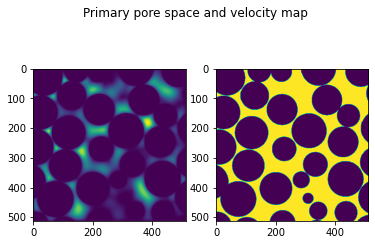

In [8]:
slice = 35

fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Primary pore space and velocity map')
p1.imshow(velDataNormPrimary[:,:,slice])
p2.imshow(primaryImage[:,:,slice])

fig.savefig('primaryPoreImage.png', dpi=300, facecolor='w', edgecolor='w')


### Generate primary porosity data

In [9]:
nRegions = np.unique(primarySnow).size
primaryPoreDiamVec = np.zeros(nRegions,)
primaryPoreVolumeVec = np.zeros(nRegions,)

for a in range(0, poreInfoPrimary['pore.diameter'].size):
    primaryPoreDiamVec[a] = poreInfoPrimary['pore.diameter'][a]
    primaryPoreVolumeVec[a] = poreInfoPrimary['pore.volume'][a]

primaryRegions = primarySnow

# Skeleton for primary image
cubeSize = len(primaryImage)
visit = np.zeros(len(np.unique(primaryRegions)))
primaryPoreDiamImage = np.zeros(primaryImage.shape)
allPrimaryRegions = np.unique(primaryRegions)
tempImage = np.zeros(primaryRegions.shape)
primaryPoreDiamVectorSkeleton = np.zeros(len(allPrimaryRegions))
primary_metric_PoreVelocity =  []
primaryMeanPoreVelocity =  []
primarySkeletonPoreDiam = []
primarySkeletonPoreRegion = []
primarySkeletonPoreVolume = []
primarySkelImage = ski.morphology.skeletonize(primaryImage)

# Save data on the skeleton
#primaryVelocitiesSkeleton = []
primaryPoreDiamSkeleton = []

primaryFiltSkelImage = np.where(primarySkelImage,True,False)
primaryVelocitiesSkeleton = velDataNormPrimary[primaryFiltSkelImage]
primaryPoreRegionSkeleton = primaryRegions[primaryFiltSkelImage]

for a in tqdm.tqdm(range(0,len(allPrimaryRegions)), 'Primary Regions loop'):
            currentRegion = a
            if currentRegion != 0: # Don't want grains to be counted
                if visit[currentRegion] == 0:
                    visit[currentRegion] = 1

                    regionImage = np.where(primaryPoreRegionSkeleton == currentRegion)
                    skeletonPoreVel = primaryVelocitiesSkeleton[regionImage]

                    primaryMeanPoreVelocity = np.append(primaryMeanPoreVelocity, np.mean(skeletonPoreVel))
                    primary_metric_PoreVelocity = np.append(primary_metric_PoreVelocity, np.median(skeletonPoreVel))

                    # Adjust indices between regionProps and snow algorithm
                    primarySkeletonPoreDiam = np.append(primarySkeletonPoreDiam,
                                                        poreInfoPrimary['pore.diameter'][currentRegion - 1])
                    primarySkeletonPoreVolume = np.append(primarySkeletonPoreVolume,
                                                          poreInfoPrimary['pore.volume'][currentRegion - 1])

                    primarySkeletonPoreRegion = np.append(primarySkeletonPoreRegion, currentRegion)


Primary Regions loop:   0%|          | 0/544 [00:00<?, ?it/s]E:\Conda\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
Primary Regions loop: 100%|██████████| 544/544 [00:00<00:00, 3697.65it/s]


### Generate secondary porosity data


In [10]:
nRegions = np.unique(secondarySnow).size
secondaryPoreDiamVec = np.zeros(nRegions,)
secondaryPoreVolumeVec = np.zeros(nRegions,)

for a in range(0, poreInfoSecondary['pore.diameter'].size):
    secondaryPoreDiamVec[a] = poreInfoSecondary['pore.diameter'][a]
    secondaryPoreVolumeVec[a] = poreInfoSecondary['pore.volume'][a]

secondaryRegions = secondarySnow

# Skeleton for secondary image
cubeSize = len(secondaryImage)
visit = np.zeros(len(np.unique(secondaryRegions)))
allSecondaryRegions = np.unique(secondaryRegions)
tempImage = np.zeros(secondaryRegions.shape)
secondaryPoreDiamVectorSkeleton = np.zeros(len(allSecondaryRegions))

#secondaryPoreVolumeImage = np.zeros((secondaryImage.shape))
#secondaryPoreRegionImage = np.zeros((secondaryImage.shape))

secondary_metric_PoreVelocity =  []
secondaryMeanPoreVelocity =  []
secondarySkeletonPoreDiam = []
secondarySkeletonPoreRegion = []
secondarySkeletonPoreVolume = []

secondarySkelImage = ski.morphology.skeletonize(secondaryImage)

# Save data on the skeleton
secondaryVelocitiesSkeleton = []
secondaryPoreDiamSkeleton = []

secondaryFiltSkelImage = np.where(secondarySkelImage,True,False)
secondaryVelocitiesSkeleton = velDataNormSecondary[secondaryFiltSkelImage]
secondaryPoreRegionSkeleton = secondaryRegions[secondaryFiltSkelImage]

for a in tqdm.tqdm(range(0,len(allSecondaryRegions)), 'Secondary Regions Loop'):
            currentRegion = a
            if currentRegion != 0: # Don't want grains to be counted
                if visit[currentRegion] == 0:
                    visit[currentRegion] = 1

                    regionImage = np.where(secondaryPoreRegionSkeleton == currentRegion)
                    skeletonPoreVel = secondaryVelocitiesSkeleton[regionImage]

                    #secondaryPoreVolumeImage[secondaryRegions == (currentRegion -1)] = poreInfoSecondary['pore.volume'][currentRegion - 1]
                    #secondaryPoreRegionImage[secondaryRegions == (currentRegion -1)] = currentRegion - 1

                    secondaryMeanPoreVelocity = np.append(secondaryMeanPoreVelocity, np.mean(skeletonPoreVel))
                    secondary_metric_PoreVelocity = np.append(secondary_metric_PoreVelocity, np.median(skeletonPoreVel))

                    # Adjust indices between regionProps and snow algorithm
                    secondarySkeletonPoreDiam = np.append(secondarySkeletonPoreDiam,
                                                          poreInfoSecondary['pore.diameter'][currentRegion - 1])
                    secondarySkeletonPoreVolume = np.append(secondarySkeletonPoreVolume,
                                                            poreInfoSecondary['pore.volume'][currentRegion - 1])

                    secondarySkeletonPoreRegion = np.append(secondarySkeletonPoreRegion, currentRegion)


Secondary Regions Loop: 100%|██████████| 6393/6393 [00:08<00:00, 715.48it/s]


In [ ]:
# Make arrays the same length for plotting
secondary_metric_PoreVelocity = np.insert(secondary_metric_PoreVelocity, 0, 0)

In [ ]:
npArray = np.array([allSecondaryRegions, secondary_metric_PoreVelocity])
npArray = np.transpose(npArray)
rowLabels = allSecondaryRegions
columnLabels = ['All secondary regions', 'Median secondary pore velocity']
df_secondaryVelocity = pd.DataFrame(data=npArray, index=rowLabels, columns=columnLabels)

In [ ]:
df_secondaryVelocity.sample(10)


In [11]:
#secondaryPoreVolumeImageOut = np.reshape(secondaryPoreVolumeImage, (imageSize**3,))
np.save('secondaryPoreVolumeImageOut.npy', secondaryPoreVolumeImage)
np.save('secondaryPoreRegionImageOut.npy', secondaryPoreRegionImage)

NameError: name 'secondaryPoreVolumeImage' is not defined

## Try masking by added pores

In [20]:
secondaryPoreVolumeImage = np.load('secondaryPoreVolumeImageOut.npy')
secondaryPoreRegionImage = np.load('secondaryPoreRegionImageOut.npy')
secondaryPoreRegionImage = secondaryPoreRegionImage.astype('int')

In [21]:
maskedSecondaryPoreVolume = np.copy(secondaryPoreVolumeImage)
maskedSecondaryPoreVolume[primaryImage == 0] = np.nan

maskedSecondaryPoreRegions = np.copy(secondaryPoreRegionImage)
maskedSecondaryPoreRegions[primaryImage == 0] = 0

maskedSecondarySkelImage = np.copy(secondarySkelImage)
maskedSecondarySkelImage = maskedSecondarySkelImage.astype('float64')
maskedSecondarySkelImage[primaryImage == 0] = 0
maskedSecondarySkelImage = maskedSecondarySkelImage.astype('bool')

maskedSecondaryVelocitiesSkeleton = np.zeros(secondaryImage.shape)

# This is the locations where the skeleton is in the interparticle porosity
maskedInd = np.where(maskedSecondarySkelImage == True)

maskedSecondaryVelocitiesSkeleton[maskedInd]  = velDataNormSecondary[maskedInd]

maskedSecondarySkelImage = maskedSecondarySkelImage.astype('float64')

maskedRegionSkelImage = np.zeros(secondaryImage.shape)
maskedRegionSkelImage[maskedInd] = maskedSecondaryPoreRegions[maskedInd]
maskedSkelRegions = np.unique(maskedRegionSkelImage)


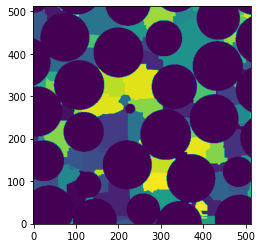

In [13]:
plt.imshow(ps.tools.randomize_colors(maskedSecondaryPoreRegions[:,:,20]), origin='lower')
# this looks reasonable


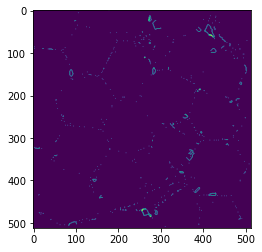

In [14]:
plt.imshow(maskedSecondarySkelImage[:,:,40])
#plt.savefig('maskedSecondarySkeleton.png', dpi=300, facecolor='w', edgecolor='w')
# this looks reasonable

## Look at within grains

In [22]:
intraPoreVolume = np.copy(secondaryPoreVolumeImage)
intraPoreVolume[primaryImage == 1] = np.nan

intraPoreRegions = np.copy(secondaryPoreRegionImage)
intraPoreRegions[primaryImage == 1] = 0

intraSkelImage = np.copy(secondarySkelImage)
intraSkelImage = intraSkelImage.astype('float64')
# Set pore space to 0
intraSkelImage[primaryImage == 1] = 0
# Cast to boolean for logic handling later
intraSkelImage = intraSkelImage.astype(bool)


intraPoreVelocitiesSkeleton = np.zeros(secondaryImage.shape)

# This is the locations where the skeleton is in the intraparticle porosity
intraInd = np.where(intraSkelImage == True)

intraPoreVelocitiesSkeleton[intraInd] = velDataNormSecondary[intraInd]


intraSkelImage = intraSkelImage.astype('float64')

intraRegionSkelImage = np.zeros(secondaryImage.shape)
intraRegionSkelImage[intraInd] = intraPoreRegions[intraInd]
intraSkelRegions = np.unique(intraRegionSkelImage)

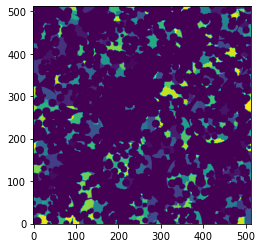

In [16]:
plt.imshow(ps.tools.randomize_colors(intraPoreRegions[:,:,20]), origin='lower')
# this looks reasonable


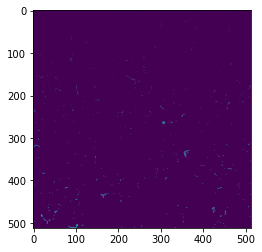

In [17]:
fig = plt.imshow(intraRegionSkelImage[:,:,40])
#plt.savefig('maskedSecondarySkeleton.png', dpi=300, facecolor='w', edgecolor='w')
# this looks reasonable

### masked region loop

In [100]:
maskedSecondaryMeanPoreVelocity = []
maskedSecondary_metric_PoreVelocity = []
maskedSecondaryPoreVolumeVector = []
maskedSecondaryPoreVelocityDataframe = np.empty(allSecondaryRegions.shape)
maskedSecondaryPoreVolumeDataframe = np.empty(allSecondaryRegions.shape)

visit = dict.fromkeys(maskedSkelRegions, 0)

for a in tqdm.tqdm(range(0,len(maskedSkelRegions)), 'Masked Regions Loop'):
            currentRegion = maskedSkelRegions[a]

            if int(currentRegion) != 0: # Don't want grains to be counted
                if visit[currentRegion] == 0:
                    visit[currentRegion] = 1

                    regionImage = np.where(maskedRegionSkelImage == currentRegion)
                    maskedPoreVel = maskedSecondaryVelocitiesSkeleton[regionImage]

                    maskedSecondaryMeanPoreVelocity = np.append(maskedSecondaryMeanPoreVelocity, np.mean(maskedPoreVel))
                    maskedSecondary_metric_PoreVelocity = np.append(maskedSecondary_metric_PoreVelocity, np.median(maskedPoreVel))

                    maskedSecondaryPoreVolumeVector = np.append(maskedSecondaryPoreVolumeVector,
                                                            poreInfoSecondary['pore.volume'][int(currentRegion) - 1])

                    maskedSecondaryPoreVelocityDataframe[int(currentRegion)] = np.median(maskedPoreVel)
                    maskedSecondaryPoreVolumeDataframe[int(currentRegion)] = poreInfoSecondary['pore.volume'][int(currentRegion) - 1 ]

Masked Regions Loop: 100%|██████████| 1424/1424 [09:30<00:00,  2.50it/s]


In [ ]:
npArray = np.array([allSecondaryRegions, secondary_metric_PoreVelocity])
npArray = np.transpose(npArray)
rowLabels = allSecondaryRegions
columnLabels = ['All secondary regions', 'Median secondary pore velocity']
df_secondaryVelocity = pd.DataFrame(data=npArray, index=rowLabels, columns=columnLabels)


In [ ]:
# Try plotting for one pore to see if it works
regionImage = np.zeros(primaryImage.shape)
test = np.where(maskedRegionSkelImage == 35)
regionImage[test] = 1
maskedPoreVel = maskedSecondaryVelocitiesSkeleton[test]
np.median(maskedPoreVel)


E:\Conda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


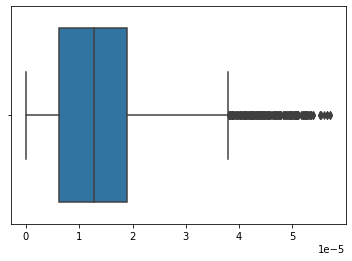

In [20]:
# Try plotting for one pore to see if it works
sns.boxplot(maskedPoreVel)

In [53]:
# Try plotting for one pore to see if it works
ps.io.to_vtk(regionImage, 'maskedRegionOut')

### intrapore region loop

In [101]:
intraPoreMeanPoreVelocity = []
intraPore_metric_PoreVelocity = []
intraPoreVolumeVector = []

intraPoreVelocityDataframe = np.empty(allSecondaryRegions.shape)
intraPoreVolumeDataframe = np.empty(allSecondaryRegions.shape)

visit = dict.fromkeys(intraSkelRegions, 0)

for a in tqdm.tqdm(range(0,len(intraSkelRegions)), 'Intrapore Regions Loop'):
            currentRegion = intraSkelRegions[a]

            if int(currentRegion) != 0: # Don't want grains to be counted
                if visit[currentRegion] == 0:
                    visit[currentRegion] = 1

                    regionImage = np.where(intraRegionSkelImage == currentRegion)
                    intraPoreSkel = intraPoreVelocitiesSkeleton[regionImage]

                    intraPoreMeanPoreVelocity = np.append(intraPoreMeanPoreVelocity, np.mean(intraPoreSkel))
                    intraPore_metric_PoreVelocity = np.append(intraPore_metric_PoreVelocity, np.median(intraPoreSkel))

                    intraPoreVolumeVector = np.append(intraPoreVolumeVector,
                                                            poreInfoSecondary['pore.volume'][int(currentRegion) - 1])

                    intraPoreVelocityDataframe[int(currentRegion)] = np.median(maskedPoreVel)
                    intraPoreVolumeDataframe[int(currentRegion)] = poreInfoSecondary['pore.volume'][int(currentRegion) - 1 ]

Intrapore Regions Loop: 100%|██████████| 6222/6222 [43:44<00:00,  2.37it/s]


In [104]:
test = np.empty(np.shape(secondaryRegions))

In [28]:
np.save('intraPore_meanVel.npy',intraPoreMeanPoreVelocity)
np.save('intraPore_metricVel.npy',intraPore_metric_PoreVelocity)
np.save('intraPoreVolumeVector.npy', intraPoreVolumeVector)
np.save('intraPoreVelocityDataframe.npy', intraPoreVelocityDataframe)
np.save('intraPoreVolumeDataframe.npy', intraPoreVolumeDataframe)

np.save('maskedPore_meanVel.npy',maskedSecondaryMeanPoreVelocity)
np.save('maskedPore_metricVel.npy',maskedSecondary_metric_PoreVelocity)
np.save('maskedPoreVolumeVector.npy', maskedSecondaryPoreVolumeVector)
np.save('maskedPoreVelocityDataframe.npy', maskedSecondaryPoreVolumeDataframe)
np.save('maskedPoreVolumeDataframe.npy', maskedSecondaryPoreVolumeDataframe)



In [29]:
intraPoreMeanPoreVelocity = np.load('intraPore_meanVel.npy')
intraPore_metric_PoreVelocity = np.load('intraPore_metricVel.npy')
intraPoreVolumeVector = np.load('intraPoreVolumeVector.npy')
intraPoreVelocityDataframe = np.load('intraPoreVelocityDataframe.npy')
intraPoreVolumeDataframe = np.load('intraPoreVolumeDataframe.npy')

maskedSecondaryMeanPoreVelocity = np.load('maskedPore_meanVel.npy')
maskedSecondary_metric_PoreVelocity = np.load('maskedPore_metricVel.npy')
maskedSecondaryPoreVolumeVector = np.load('maskedPoreVolumeVector.npy')
maskedSecondaryPoreVolumeDataframe = np.load('maskedPoreVolumeDataframe.npy')
maskedSecondaryPoreVelocityDataframe = np.load('maskedPoreVelocityDataframe.npy')

In [ ]:
#np.where(maskedSecondaryPoreRegions == 62)

## Plot masked and unmasked secondary skeleton velocity


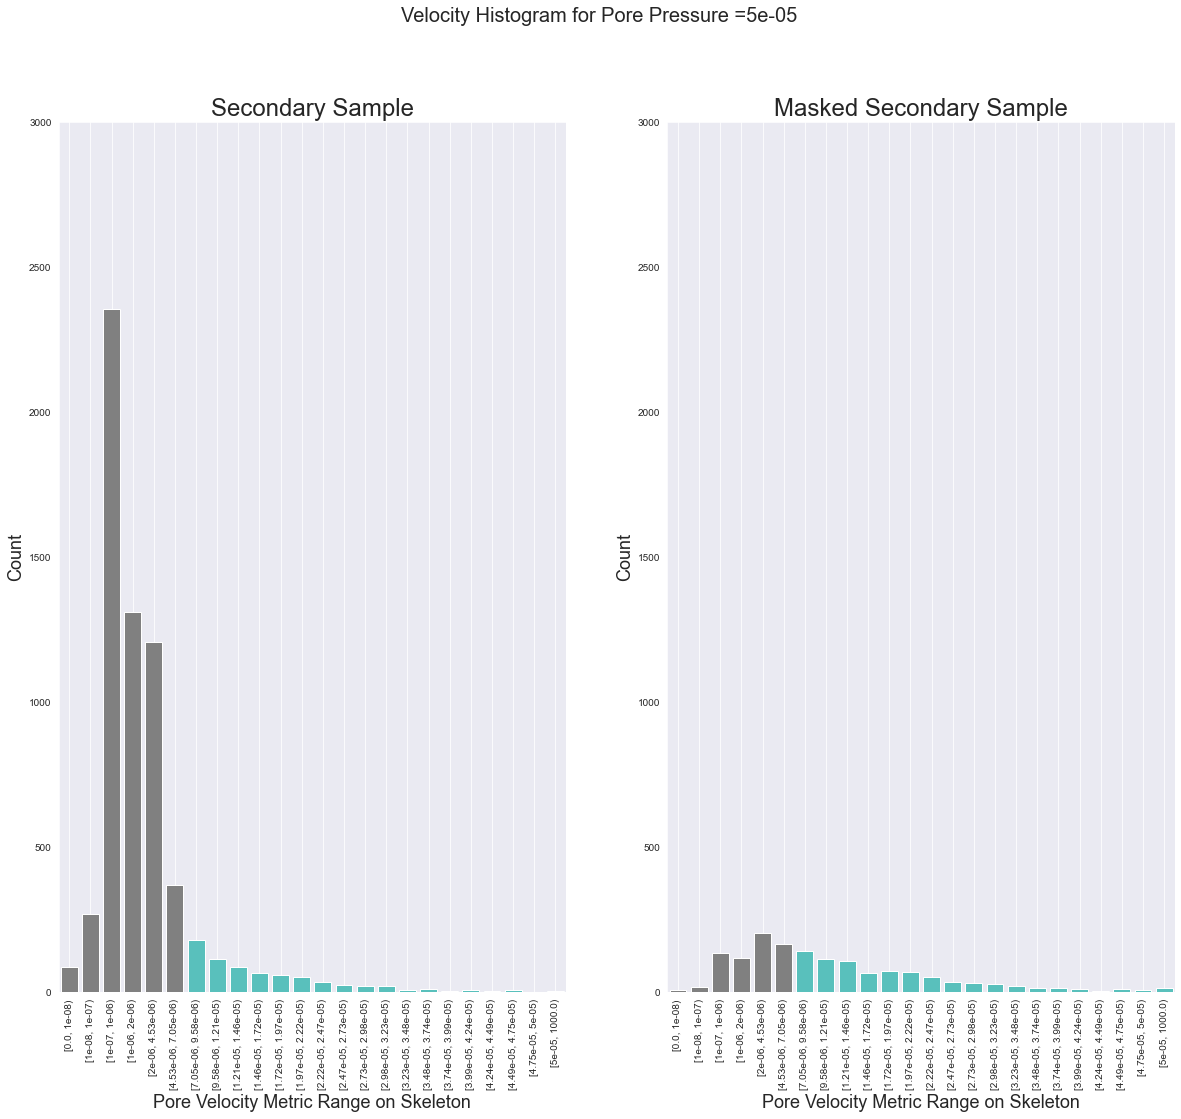

In [30]:
bins = np.linspace(0.000002, 0.00005, num=20)
#np.append(bins,0.0001)
bins = np.append(bins, 1000)
bins = np.insert(bins, 0, 0)
bins = np.insert(bins, 1, 0.00000001)
bins = np.insert(bins, 2, 0.0000001)
bins = np.insert(bins, 3, 0.000001)

df_secondaryAll = pd.DataFrame({'skelVelSecondaryAll': secondary_metric_PoreVelocity,
                        'vel_groupSecondaryAll': pd.cut(secondary_metric_PoreVelocity, bins=bins, right=False)})

df_secondaryMask = pd.DataFrame({'skelVelSecondaryMask': maskedSecondary_metric_PoreVelocity,
                        'vel_groupSecondaryMask': pd.cut(maskedSecondary_metric_PoreVelocity, bins=bins, right=False)})


############################################################
yMax = 3000

binClrs = ['grey' if (x < lowFlowVelCutoff) else 'mediumturquoise' for x in bins]

fig, axes = plt.subplots(1, 2, figsize=(20, 16))
fig.suptitle('Velocity Histogram for Pore Pressure ='+str(simPressure), fontsize=20)

sns.countplot(data=df_secondaryAll,x='vel_groupSecondaryAll',ax=axes[0], palette=binClrs)
sns.countplot(data=df_secondaryMask,x='vel_groupSecondaryMask',ax=axes[1], palette=binClrs)

axes[0].set_title('Secondary Sample', fontsize=24)
axes[0].tick_params(axis='x', labelrotation=90)
axes[0].set_ylim([0,yMax])
axes[0].set_xlabel('Pore Velocity Metric Range on Skeleton', fontsize=18)
axes[0].set_ylabel('Count', fontsize=18)
axes[0].grid()

axes[1].set_title('Masked Secondary Sample', fontsize=24)
axes[1].tick_params(axis='x', labelrotation=90)
axes[1].set_ylim([0,yMax])
axes[1].set_xlabel('Pore Velocity Metric Range on Skeleton', fontsize=18)
axes[1].set_ylabel('Count', fontsize=18)
axes[1].grid()

figStr = 'poreVelocityHistMaskedSecondary_pressure_'+str(simPressure)+'.png'

fig.savefig(figStr, dpi=300, facecolor='w', edgecolor='w')

## Plot inter and intragranular porosity


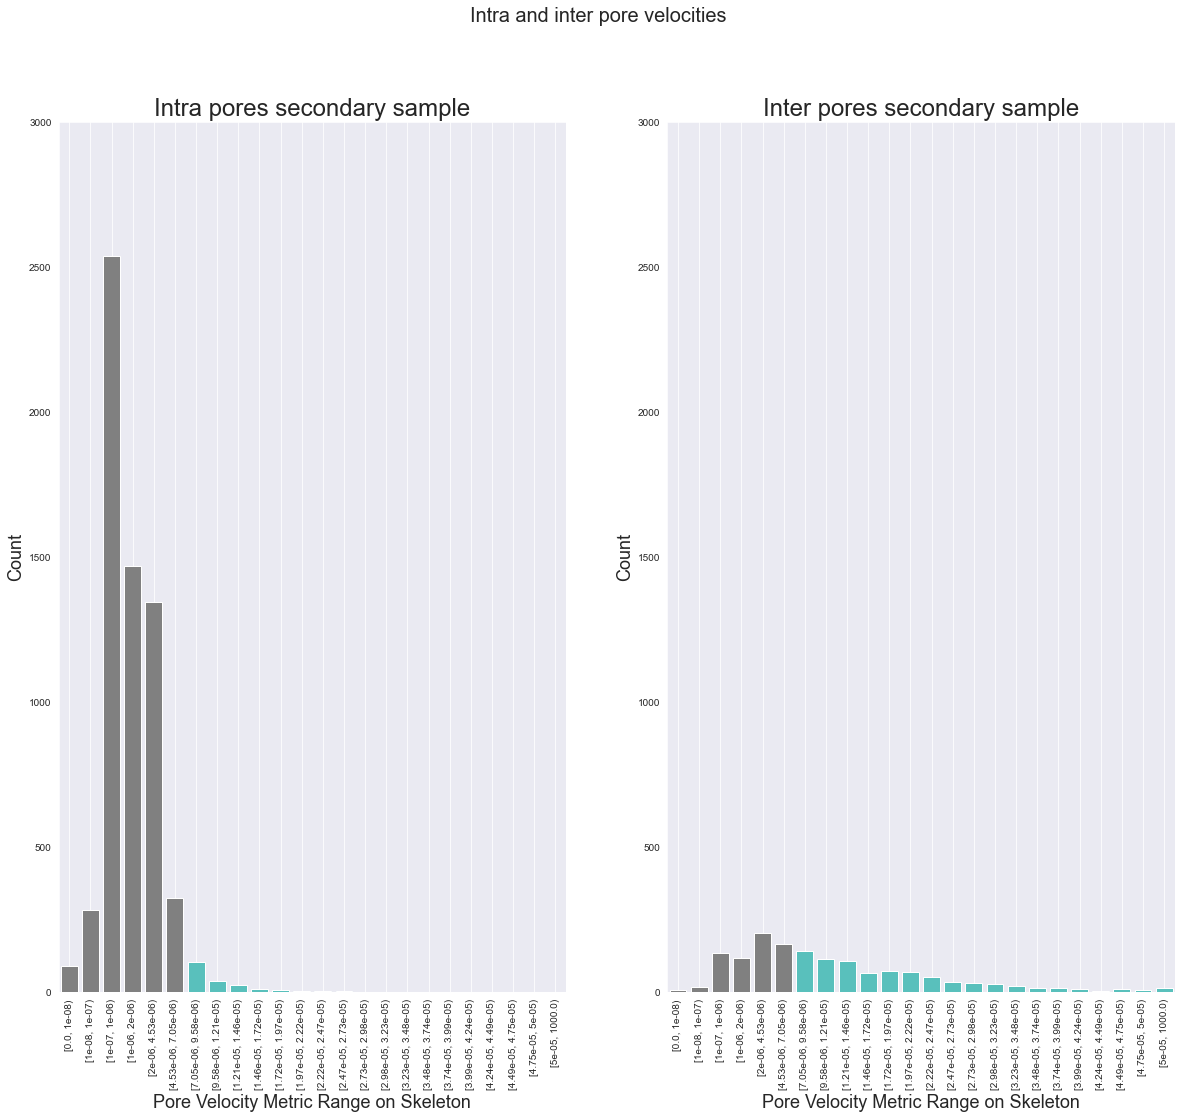

In [31]:
bins = np.linspace(0.000002, 0.00005, num=20)
#np.append(bins,0.0001)
bins = np.append(bins, 1000)
bins = np.insert(bins, 0, 0)
bins = np.insert(bins, 1, 0.00000001)
bins = np.insert(bins, 2, 0.0000001)
bins = np.insert(bins, 3, 0.000001)

df_secondaryIntra = pd.DataFrame({'skelVelIntraPore': intraPore_metric_PoreVelocity,
                        'vel_groupIntraPore': pd.cut(intraPore_metric_PoreVelocity, bins=bins, right=False)})

df_secondaryInter= pd.DataFrame({'skelVelInterPore': maskedSecondary_metric_PoreVelocity,
                        'vel_groupInterPore': pd.cut(maskedSecondary_metric_PoreVelocity, bins=bins, right=False)})


############################################################
yMax = 3000

binClrs = ['grey' if (x < lowFlowVelCutoff) else 'mediumturquoise' for x in bins]

fig, axes = plt.subplots(1, 2, figsize=(20, 16))
fig.suptitle('Intra and inter pore velocities', fontsize=20)

sns.countplot(data=df_secondaryIntra,x='vel_groupIntraPore',ax=axes[0], palette=binClrs)
sns.countplot(data=df_secondaryInter,x='vel_groupInterPore',ax=axes[1], palette=binClrs)

axes[0].set_title('Intra pores secondary sample', fontsize=24)
axes[0].tick_params(axis='x', labelrotation=90)
axes[0].set_ylim([0,yMax])
axes[0].set_xlabel('Pore Velocity Metric Range on Skeleton', fontsize=18)
axes[0].set_ylabel('Count', fontsize=18)
axes[0].grid()

axes[1].set_title('Inter pores secondary sample', fontsize=24)
axes[1].tick_params(axis='x', labelrotation=90)
axes[1].set_ylim([0,yMax])
axes[1].set_xlabel('Pore Velocity Metric Range on Skeleton', fontsize=18)
axes[1].set_ylabel('Count', fontsize=18)
axes[1].grid()

figStr = 'interAndIntraPoreVelocity_pressure_'+str(simPressure)+'.png'

fig.savefig(figStr, dpi=300, facecolor='w', edgecolor='w')

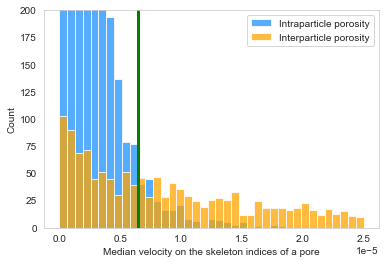

In [73]:
velBins = np.linspace(0, 0.000025, num=40)
fig, ax =  plt.subplots()
sns.set_style('whitegrid')

sns.histplot(data=intraPore_metric_PoreVelocity, bins=velBins,
            common_bins=True, ax=ax, color="dodgerblue", label="Intraparticle porosity")
sns.histplot(data=maskedSecondary_metric_PoreVelocity,bins=velBins,ax=ax,color="orange", label="Interparticle porosity")
plt.legend()
plt.grid()
ax.set_ylim([0,200])
ax.set_xlabel('Median velocity on the skeleton indices of a pore')

lowFlowVelCutoff = 6.5 * 10 ** float(-6) #0.000207 # 5.13 * 10 ** float(-5) # 0.5 * 10 ** float(-5)
ax.plot([lowFlowVelCutoff , lowFlowVelCutoff],[0,200],'g',lw=3)

figStr = 'poreVelocityHist_pressure_'+str(simPressure)+'.png'
#fig.show()
fig.savefig(figStr, dpi=300, facecolor='w', edgecolor='w')

E:\Conda\lib\site-packages\seaborn\distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
E:\Conda\lib\site-packages\seaborn\distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
SOURCE     : matplotlib.legend._parse_legend_args 
TIME STAMP : 2021-05-05 16:52:08,314


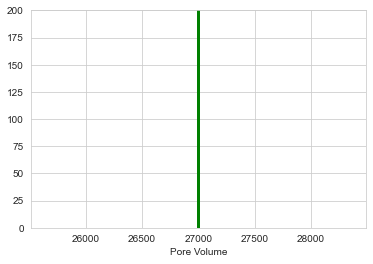

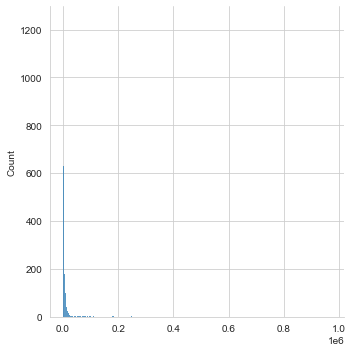

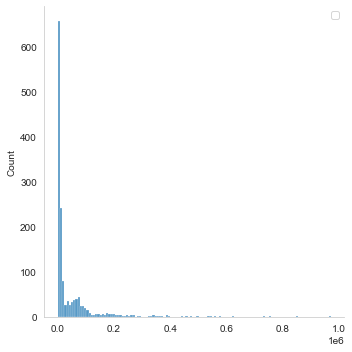

In [78]:
# Look at pore volume
volumeBins = np.linspace(0, 200000, num=40)
fig, ax2 =  plt.subplots()
sns.set_style('whitegrid')

# sns.histplot(data=intraPoreVolumeVector, bins=volumeBins,
#             common_bins=True, ax=ax2, color="dodgerblue", label="Intraparticle porosity")
# sns.histplot(data=maskedSecondaryPoreVolumeVector,bins=volumeBins,ax=ax2,color="orange",
#              label="Interparticle porosity")

sns.displot(data=intraPoreVolumeVector,ax=ax2)
sns.displot(data=maskedSecondaryPoreVolumeVector, ax=ax2
)

plt.legend()
plt.grid()
ax2.set_ylim([0,200])
ax2.set_xlabel('Pore Volume')

poreVolumeCutoff = 27000
ax2.plot([poreVolumeCutoff, poreVolumeCutoff],[0,200],'g',lw=3)

figStr = 'poreVolumeMaskedHist_'+str(simPressure)+'.png'
#fig.show()
fig.savefig(figStr, dpi=300, facecolor='w', edgecolor='w')

In [28]:
#px.box(maskedSecondary_metric_PoreVelocity,orientation='h', points='all')
#ax.set_legend('Intraparticle porosity', 'Interparticle porosity')

In [9]:
# Try to filter SNOW Regions by pore volume

smallPoreRegions = np.where(secondaryPoreVolumeVec < poreVolumeThresh)
smallPoreVolume = secondaryPoreVolumeVec[smallPoreRegions]

smallPoreSkelRegions = np.where(secondarySkeletonPoreVolume < poreVolumeThresh)
smallPoreSkelVolume = secondarySkeletonPoreRegion[smallPoreSkelRegions]
smallPoreSkelVel = secondary_metric_PoreVelocity[smallPoreSkelRegions]


# Plotting Section

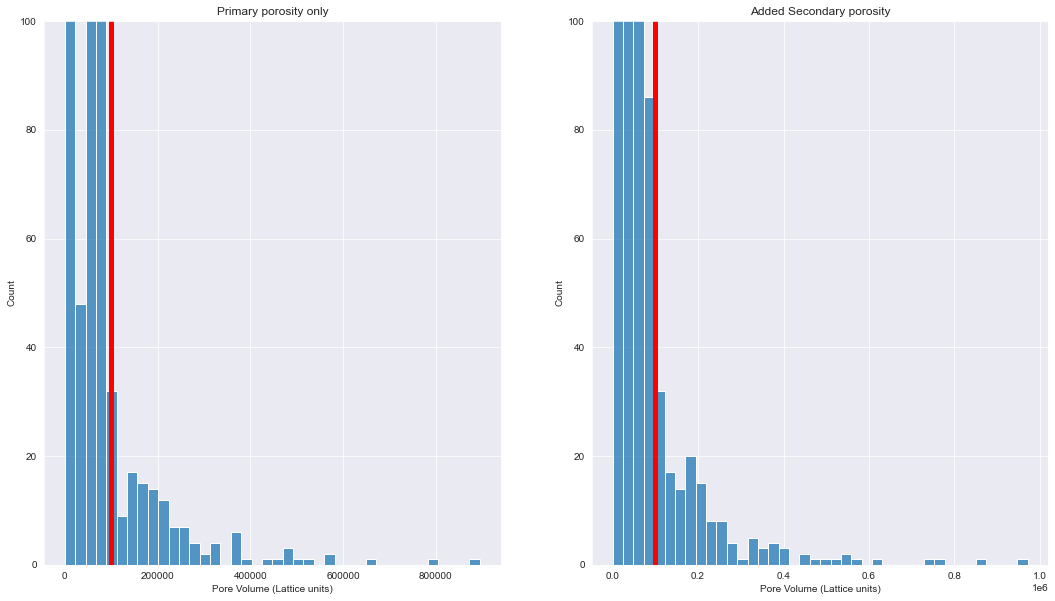

In [29]:
yMax = 100
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

sns.histplot(data=primaryPoreVolumeVec, ax=axes[0],
             bins=int(40))
axes[0].set_title('Primary porosity only')
axes[0].set_xlabel('Pore Volume (Lattice units)')
axes[0].set_ylim([0,yMax])
axes[0].plot([poreVolumeThresh, poreVolumeThresh],[0,yMax],'r',lw=5)

sns.histplot(data=secondaryPoreVolumeVec, ax=axes[1],
             bins=int(40))
axes[1].set_title('Added Secondary porosity')
axes[1].set_xlabel('Pore Volume (Lattice units)')
axes[1].set_ylim([0,yMax])
axes[1].plot([poreVolumeThresh, poreVolumeThresh],[0,yMax],'r',lw=5)

figStr = 'poreVolumeHist_pressure_'+str(simPressure)+'.png'
#fig.show()
fig.savefig(figStr, dpi=300, facecolor='w', edgecolor='w')

## Investigate pore volume with histogram

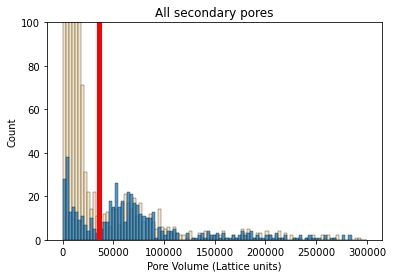

In [12]:
yMax = 100
poreVolumeThresh = 36000

fig = plt.figure()
binLims = np.linspace(0,300000,100)

sns.histplot(data=secondaryPoreVolumeVec,
             bins=binLims,color='wheat',stat='count')
sns.histplot(data=primaryPoreVolumeVec,
             bins=binLims)

plt.title('All secondary pores')
plt.xlabel('Pore Volume (Lattice units)')
plt.ylim([0,yMax])
plt.plot([poreVolumeThresh, poreVolumeThresh],[0,yMax],'r',lw=5)

## Investigate pore volume with plotly

In [13]:
binTest = {"start":0,"end":300000,"size":3000}
fig = go.Figure()
fig.add_trace(go.Histogram(x=secondaryPoreVolumeVec,xbins=binTest,name='Secondary Porosity'))
fig.add_trace(go.Histogram(x=primaryPoreVolumeVec,xbins=binTest,name='Primary Porosity'))
fig.add_vline(x=poreVolumeThresh, line_width=3, line_dash="dash", line_color="green")

# Overlay both histograms

fig.update_layout(
    barmode="overlay",
    bargap=0.1)
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.update_layout(yaxis_range=[0,100])
fig.show()


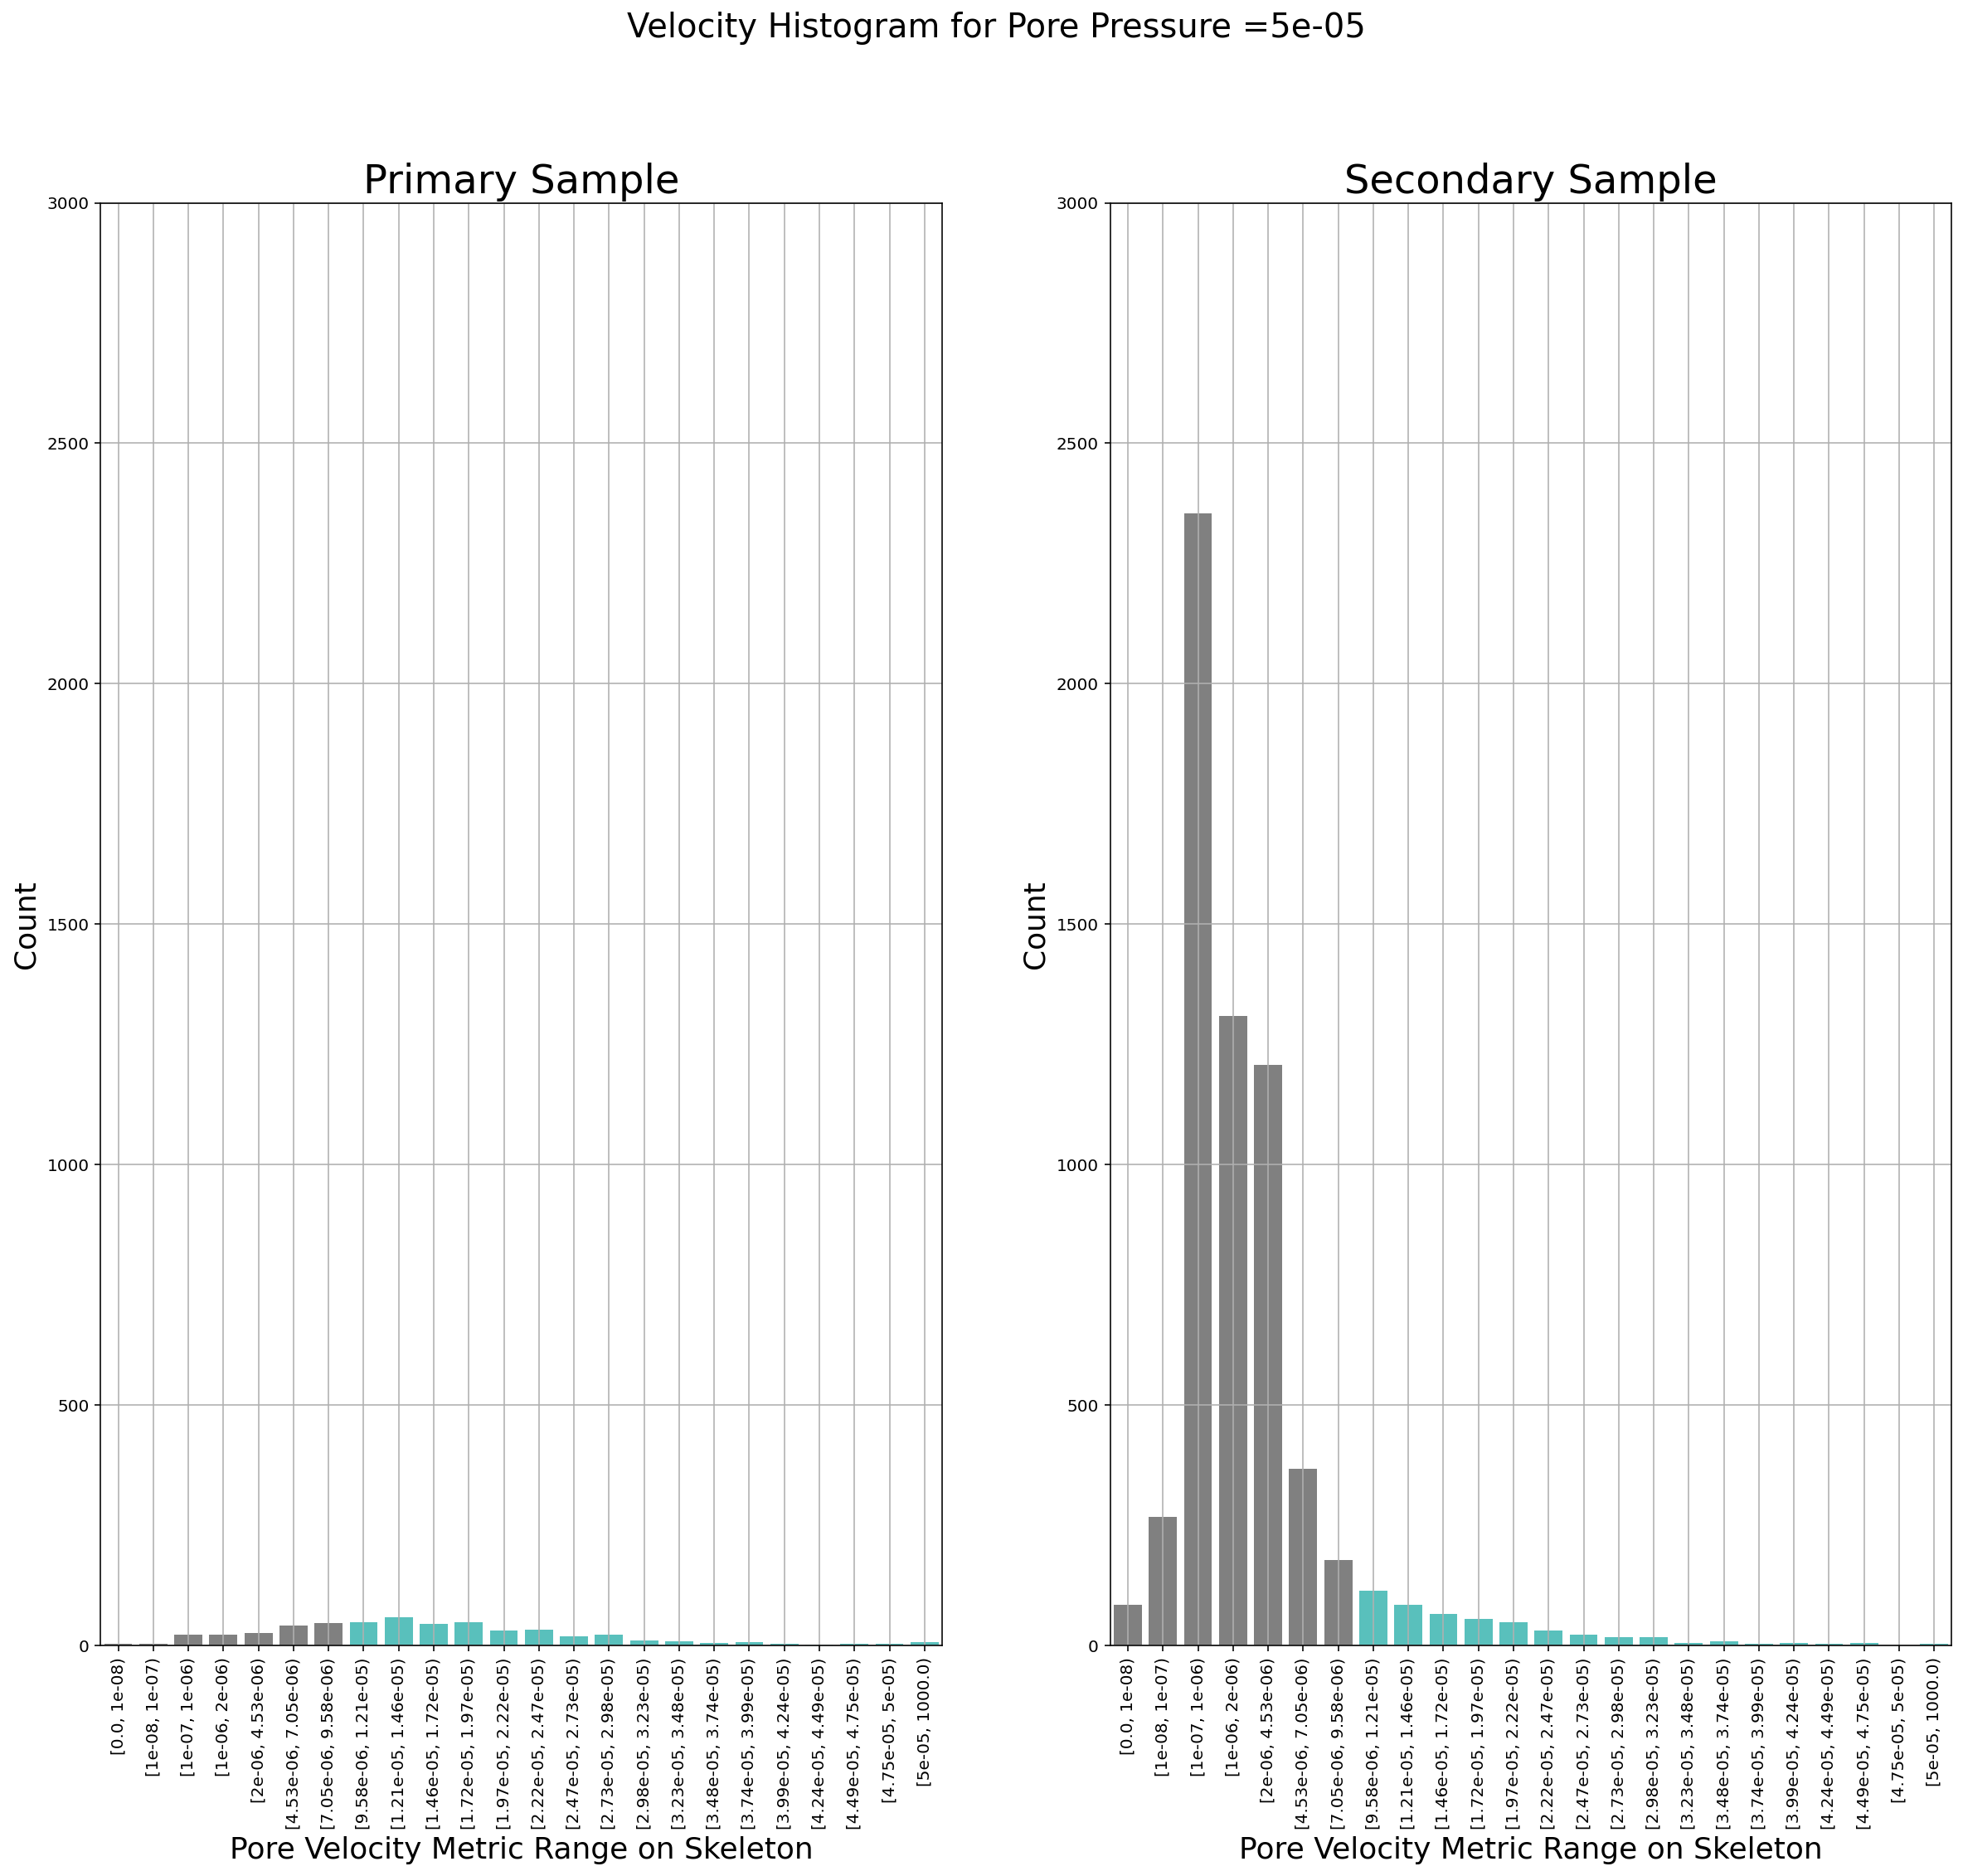

In [84]:
bins = np.linspace(0.000002, 0.00005, num=20)
#np.append(bins,0.0001)
bins = np.append(bins, 1000)
bins = np.insert(bins, 0, 0)
bins = np.insert(bins, 1, 0.00000001)
bins = np.insert(bins, 2, 0.0000001)
bins = np.insert(bins, 3, 0.000001)

np.save('medianPrimaryPoreVel.npy',primary_metric_PoreVelocity)
np.save('medianSecondaryPoreVel.npy',secondary_metric_PoreVelocity)

df_primary = pd.DataFrame({'skelVelPrimary': primary_metric_PoreVelocity,
                        'vel_groupPrimary': pd.cut(primary_metric_PoreVelocity, bins=bins, right=False)})

df_secondary = pd.DataFrame({'skelVelSecondary': secondary_metric_PoreVelocity,
                        'vel_groupSecondary': pd.cut(secondary_metric_PoreVelocity, bins=bins, right=False)})


############################################################
yMax = 3000

primaryClrs = ['grey' if (x < lowFlowVelCutoff) else 'mediumturquoise' for x in bins ]
secondaryClrs = ['grey' if (x < lowFlowVelCutoff) else 'mediumturquoise' for x in bins]

fig, axes = plt.subplots(1, 2, figsize=(20, 16))
fig.suptitle('Velocity Histogram for Pore Pressure ='+str(simPressure), fontsize=20)

sns.countplot(data=df_primary,x='vel_groupPrimary',ax=axes[0], palette=primaryClrs)
sns.countplot(data=df_secondary,x='vel_groupSecondary',ax=axes[1], palette=secondaryClrs)

axes[0].set_title('Primary Sample', fontsize=24)
axes[0].tick_params(axis='x', labelrotation=90)
axes[0].set_ylim([0,yMax])
axes[0].set_xlabel('Pore Velocity Metric Range on Skeleton', fontsize=18)
axes[0].set_ylabel('Count', fontsize=18)
axes[0].grid()

axes[1].set_title('Secondary Sample', fontsize=24)
axes[1].tick_params(axis='x', labelrotation=90)
axes[1].set_ylim([0,yMax])
axes[1].set_xlabel('Pore Velocity Metric Range on Skeleton', fontsize=18)
axes[1].set_ylabel('Count', fontsize=18)
axes[1].grid()

figStr = 'poreVelocityHist_pressure_'+str(simPressure)+'.png'

fig.savefig(figStr, dpi=300, facecolor='w', edgecolor='w')

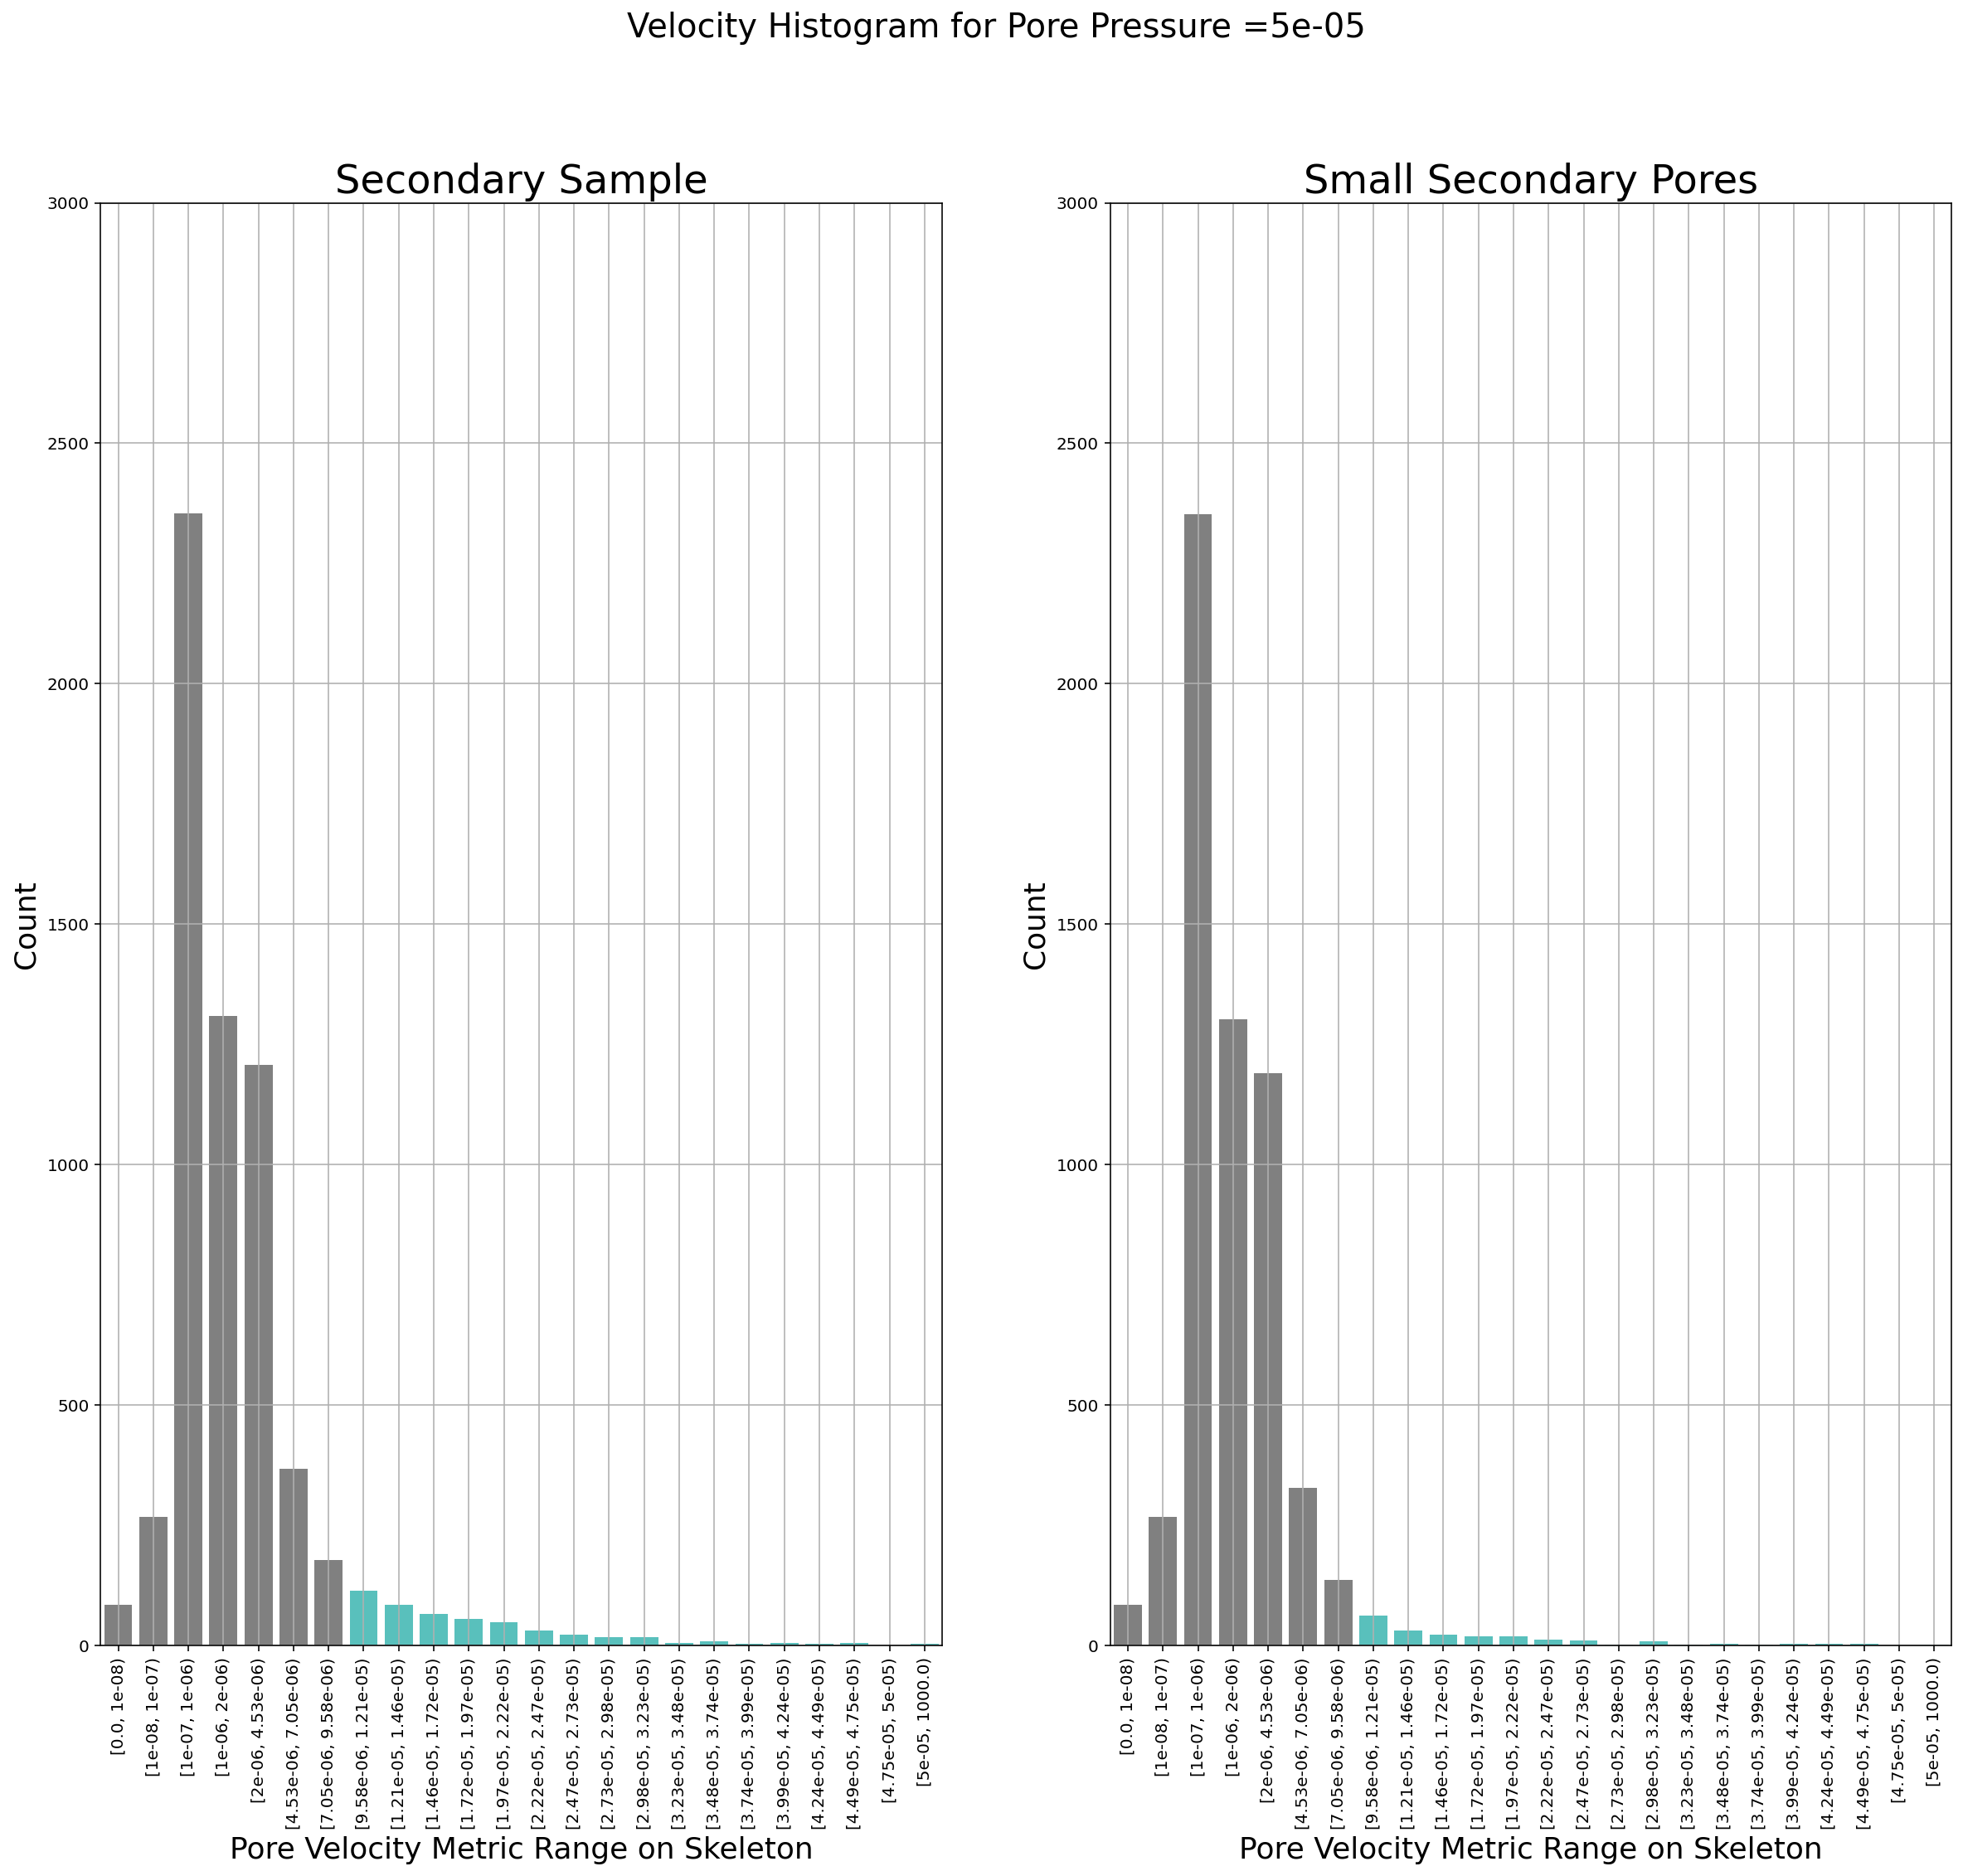

In [90]:
bins = np.linspace(0.000002, 0.00005, num=20)
#np.append(bins,0.0001)
bins = np.append(bins, 1000)
bins = np.insert(bins, 0, 0)
bins = np.insert(bins, 1, 0.00000001)
bins = np.insert(bins, 2, 0.0000001)
bins = np.insert(bins, 3, 0.000001)

df_secondarySmall = pd.DataFrame({'skelVelSecondarySmall': smallPoreSkelVel,
                        'vel_groupSecondarySmall': pd.cut(smallPoreSkelVel, bins=bins, right=False)})

df_secondary = pd.DataFrame({'skelVelSecondary': secondary_metric_PoreVelocity,
                        'vel_groupSecondary': pd.cut(secondary_metric_PoreVelocity, bins=bins, right=False)})


############################################################
yMax = 3000

secondarySmallClrs = ['grey' if (x < lowFlowVelCutoff) else 'mediumturquoise' for x in bins ]
secondaryClrs = ['grey' if (x < lowFlowVelCutoff) else 'mediumturquoise' for x in bins]

fig, axes = plt.subplots(1, 2, figsize=(20, 16))
fig.suptitle('Velocity Histogram for Pore Pressure ='+str(simPressure), fontsize=20)

sns.countplot(data=df_secondary,x='vel_groupSecondary',ax=axes[0], palette=secondaryClrs)
sns.countplot(data=df_secondarySmall,x='vel_groupSecondarySmall',ax=axes[1], palette=secondarySmallClrs)

axes[0].set_title('Secondary Sample', fontsize=24)
axes[0].tick_params(axis='x', labelrotation=90)
axes[0].set_ylim([0,yMax])
axes[0].set_xlabel('Pore Velocity Metric Range on Skeleton', fontsize=18)
axes[0].set_ylabel('Count', fontsize=18)
axes[0].grid()

axes[1].set_title('Small Secondary Pores', fontsize=24)
axes[1].tick_params(axis='x', labelrotation=90)
axes[1].set_ylim([0,yMax])
axes[1].set_xlabel('Pore Velocity Metric Range on Skeleton', fontsize=18)
axes[1].set_ylabel('Count', fontsize=18)
axes[1].grid()

figStr = 'poreVelocityHistSecondary_pressure_'+str(simPressure)+'.png'

fig.savefig(figStr, dpi=300, facecolor='w', edgecolor='w')


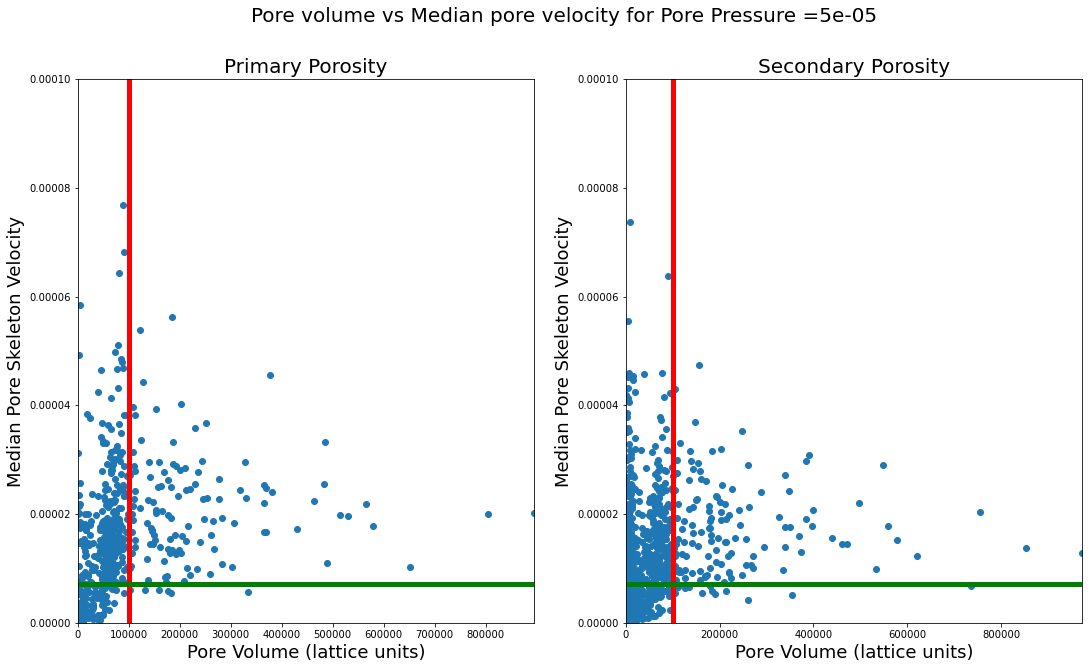

In [14]:

########################################

yMax = 0.0001

fig, axes = plt.subplots(1, 2, figsize=(18, 10))
fig.suptitle('Pore volume vs Median pore velocity for Pore Pressure ='+str(simPressure), fontsize=20)

axes[0].scatter(primarySkeletonPoreVolume, primary_metric_PoreVelocity)
axes[0].set_xlabel('Pore Volume (lattice units)', fontsize=18)
axes[0].set_ylabel('Median Pore Skeleton Velocity', fontsize=18)
axes[0].set_title('Primary Porosity', fontsize=20)
axes[0].set_ylim([0,yMax])
axes[0].set_xlim([0,np.max(primarySkeletonPoreVolume)])
axes[0].plot([poreVolumeThresh, poreVolumeThresh],[0,yMax],'r',lw=5)
axes[0].plot([0,np.max(primarySkeletonPoreVolume)],[lowFlowVelCutoff, lowFlowVelCutoff],'g',lw=5)

axes[1].scatter(secondarySkeletonPoreVolume, secondary_metric_PoreVelocity)
axes[1].set_xlabel('Pore Volume (lattice units)', fontsize=18)
axes[1].set_ylabel('Median Pore Skeleton Velocity', fontsize=18)
axes[1].set_title('Secondary Porosity', fontsize=20)
axes[1].set_ylim([0,yMax])
axes[1].set_xlim([0,np.max(secondarySkeletonPoreVolume)])
axes[1].plot([poreVolumeThresh, poreVolumeThresh],[0,yMax],'r',lw=5)
axes[1].plot([0,np.max(secondarySkeletonPoreVolume)],[lowFlowVelCutoff, lowFlowVelCutoff],'g',lw=5)

figStr = 'poreRegion_pressure_'+str(simPressure)+'.png'

fig.savefig(figStr, dpi=300, facecolor='w', edgecolor='w')




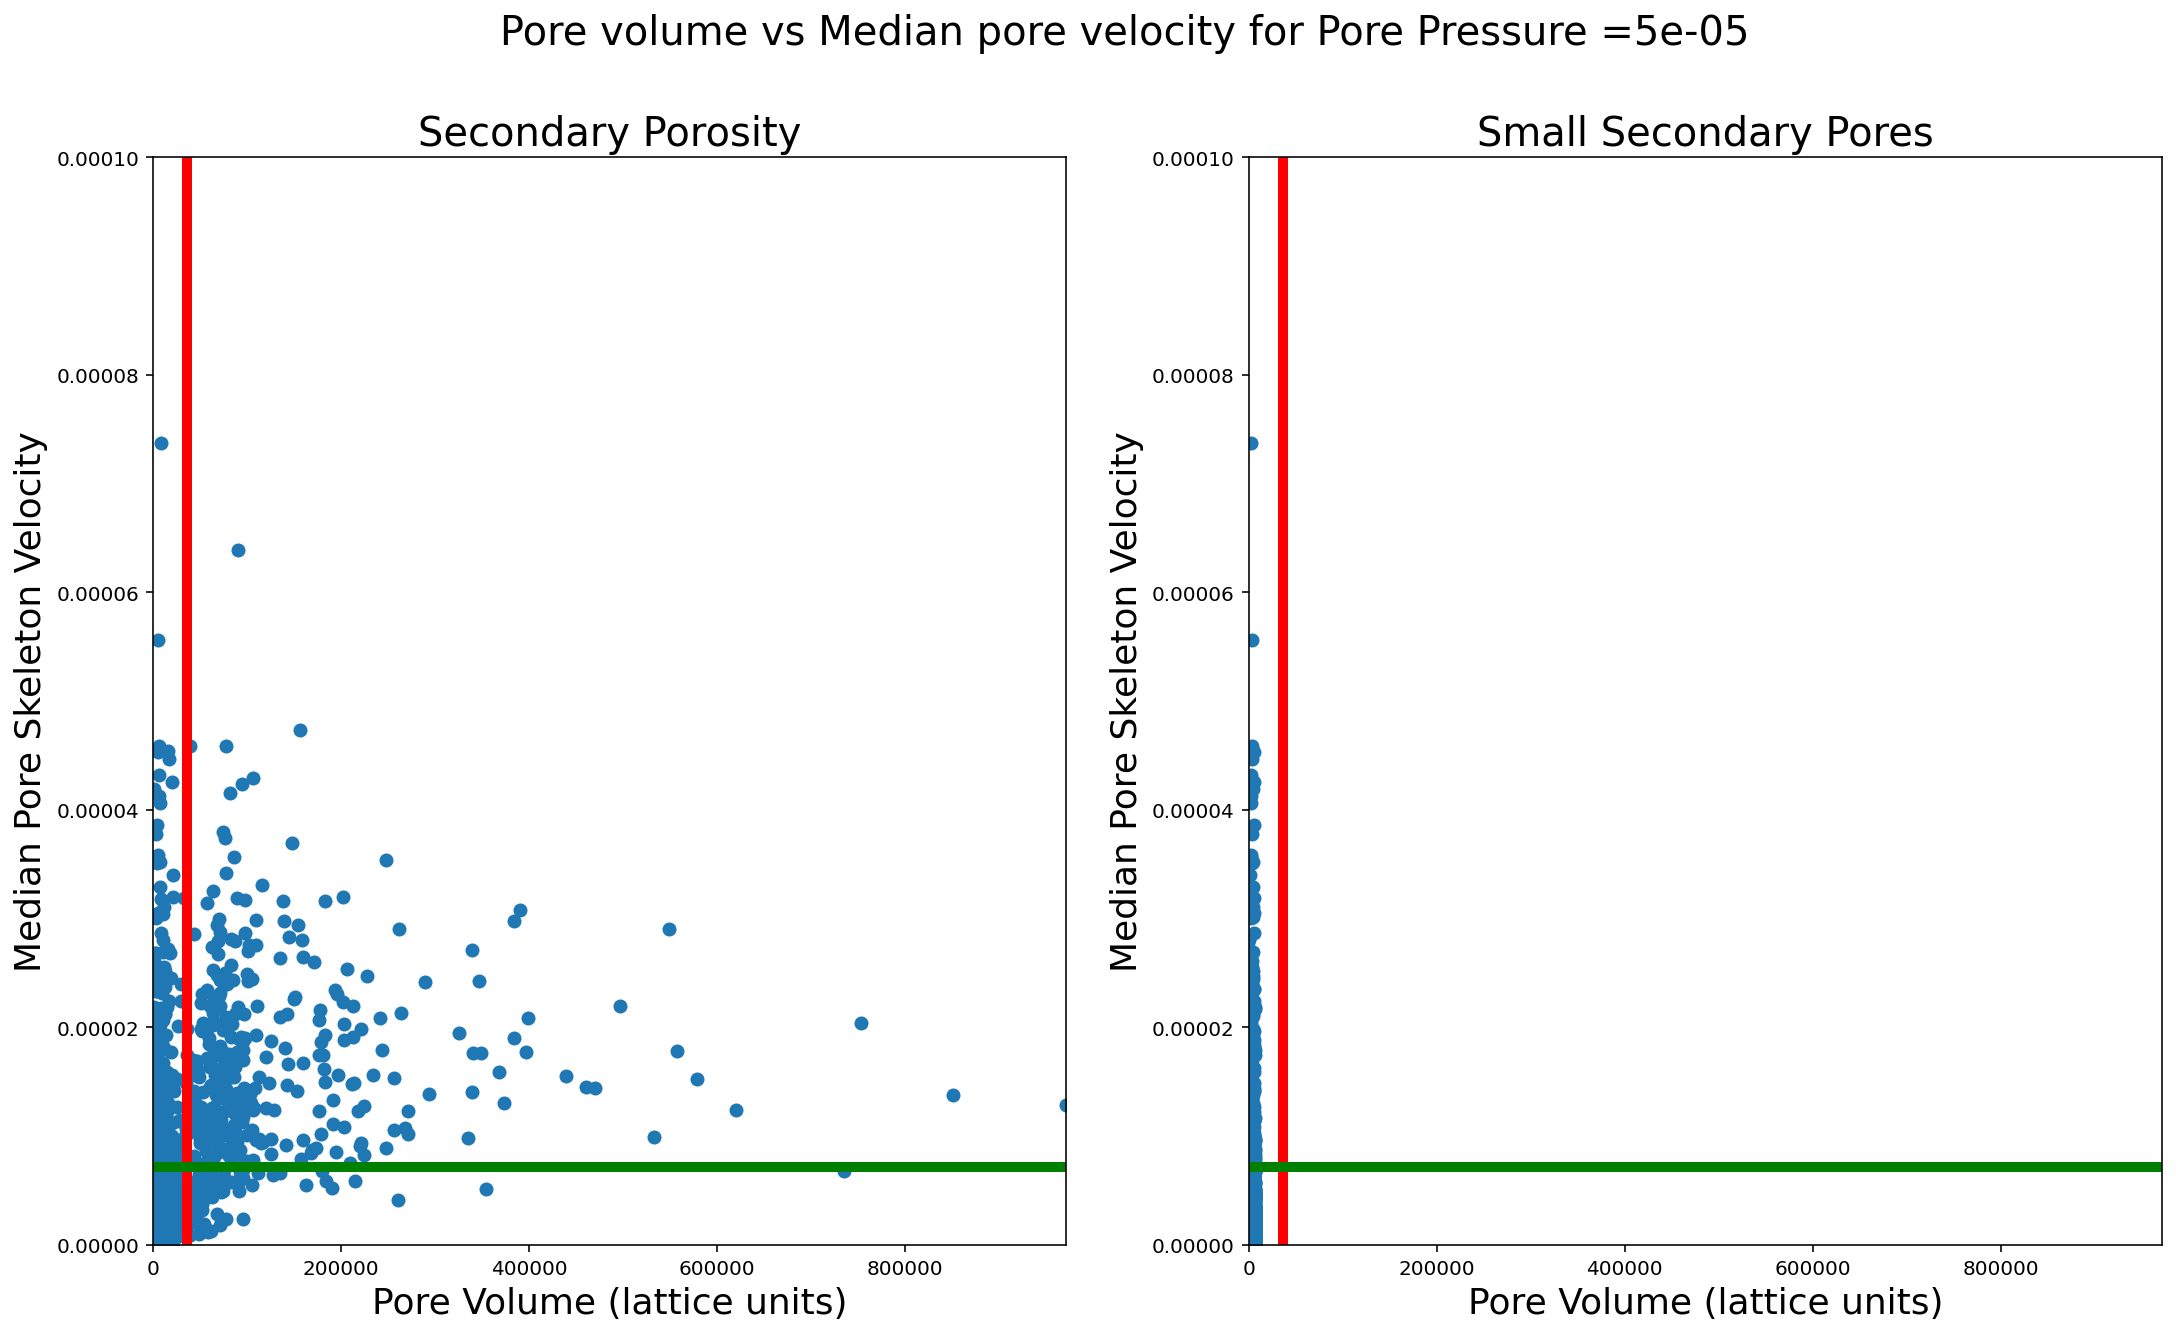

In [87]:
########################################

yMax = 0.0001

fig, axes = plt.subplots(1, 2, figsize=(18, 10))
fig.suptitle('Pore volume vs Median pore velocity for Pore Pressure ='+str(simPressure), fontsize=20)

axes[0].scatter(secondarySkeletonPoreVolume, secondary_metric_PoreVelocity)
axes[0].set_xlabel('Pore Volume (lattice units)', fontsize=18)
axes[0].set_ylabel('Median Pore Skeleton Velocity', fontsize=18)
axes[0].set_title('Secondary Porosity', fontsize=20)
axes[0].set_ylim([0,yMax])
axes[0].set_xlim([0,np.max(secondarySkeletonPoreVolume)])
axes[0].plot([poreVolumeThresh, poreVolumeThresh],[0,yMax],'r',lw=5)
axes[0].plot([0,np.max(secondarySkeletonPoreVolume)],[lowFlowVelCutoff, lowFlowVelCutoff],'g',lw=5)

axes[1].scatter(smallPoreSkelVolume, smallPoreSkelVel)
axes[1].set_xlabel('Pore Volume (lattice units)', fontsize=18)
axes[1].set_ylabel('Median Pore Skeleton Velocity', fontsize=18)
axes[1].set_title('Small Secondary Pores', fontsize=20)
axes[1].set_ylim([0,yMax])
axes[1].set_xlim([0,np.max(secondarySkeletonPoreVolume)])
axes[1].plot([poreVolumeThresh, poreVolumeThresh],[0,yMax],'r',lw=5)
axes[1].plot([0,np.max(secondarySkeletonPoreVolume)],[lowFlowVelCutoff, lowFlowVelCutoff],'g',lw=5)

figStr = 'poreRegion_pressure_'+str(simPressure)+'.png'

fig.savefig(figStr, dpi=300, facecolor='w', edgecolor='w')

